# Progress Report

1. I have the data I originally planned on using in hand. However, the data I have is only for the top 5000 games. Board Game Geek has an API, which is how the data was originally obtained (and loaded as a Kaggle dataset by someone else). In theory, I should be able to pull the data for all of the games through the API, but I haven't gotten farther than looking at the docs for the API.

2. I've done a fair bit of EDA on the data I have, but additional EDA would be required if I use the full dataset. The main things I've done so far are look at pairplots, heatmaps, and histograms for the numerical columns. I haven't done any EDA with the categorical fields.

3. I have started the modeling process and tried ElasticNet, KNeighborsRegressor, and RandomForestRegressor using a GridSearch. The best score (r^2) I've been able to achieve to date is 0.35. 

4. The biggest issue right now is trying to acquire the full database via the BGG API. I think I can figure it out if I spend some more time working with it. Also, I'm worried that the data I have just might not have that much predictive power. Maybe I need to try more feature engineering?

5. I haven't changed topcis since my lightning talk.

6. I would like to get the whole database for all games on the site in the next day or so. I'd also like to tinker some more with the categorical columns. I plan to try out a NN within the next week as well. A stretch goal of mine is to create a recommendation engine using user reviews that you can pull from the API. 

7. There's nothing in particular I feel I need to discuss. The main thing I guess is how to determine how "good" my model is when I don't really have a baseline for my regression problem (I suppose I could use the rms error when just predicting the mean value or something?).

In [116]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, RFE, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_union, make_pipeline, FeatureUnion, Pipeline
from sklearn.linear_model import ElasticNet, LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, FunctionTransformer, MinMaxScaler, \
    Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
import requests
import xmltodict
import time

%matplotlib inline

# EDA/Preprocessing

In [3]:
df = pd.read_csv('datasets/bgg_db_2017_04.csv',encoding='cp1250')
df.head(3) 

,rank,bgg_url,game_id,names,min_players,max_players,avg_time,min_time,max_time,year,avg_rating,geek_rating,num_votes,image_url,age,mechanic,owned,category,designer,weight
0,1,https://boardgamegeek.com/boardgame/161936/pan...,161936,Pandemic Legacy: Season 1,2,4,60,60,60,2015,8.66905,8.48904,18009,https://cf.geekdo-images.com/images/pic2452831...,13,"Action Point Allowance System, Co-operative Pl...",29472,"Environmental, Medical","Rob Daviau, Matt Leacock",2.8076
1,2,https://boardgamegeek.com/boardgame/182028/thr...,182028,Through the Ages: A New Story of Civilization,2,4,240,180,240,2015,8.72977,8.30744,7309,https://cf.geekdo-images.com/images/pic2663291...,14,"Action Point Allowance System, Auction/Bidding...",10007,"Card Game, Civilization, Economic",Vlaada Chvátil,4.3093
2,3,https://boardgamegeek.com/boardgame/12333/twil...,12333,Twilight Struggle,2,2,180,180,180,2005,8.35745,8.22021,27403,https://cf.geekdo-images.com/images/pic361592.jpg,13,"Area Control / Area Influence, Campaign / Batt...",37382,"Modern Warfare, Political, Wargame","Ananda Gupta, Jason Matthews",3.5317


In [4]:
#drop columns that only contain unique values for each game
df.drop(['bgg_url','game_id','image_url'],axis=1,inplace=True)
#drop rank as it's just a proxy for geek_rating
df.drop('rank',axis=1,inplace=True)
#drop columns that new games won't have
df.drop(['num_votes','owned'],axis=1,inplace=True)
df.head(3)

,names,min_players,max_players,avg_time,min_time,max_time,year,avg_rating,geek_rating,age,mechanic,category,designer,weight
0,Pandemic Legacy: Season 1,2,4,60,60,60,2015,8.66905,8.48904,13,"Action Point Allowance System, Co-operative Pl...","Environmental, Medical","Rob Daviau, Matt Leacock",2.8076
1,Through the Ages: A New Story of Civilization,2,4,240,180,240,2015,8.72977,8.30744,14,"Action Point Allowance System, Auction/Bidding...","Card Game, Civilization, Economic",Vlaada Chvátil,4.3093
2,Twilight Struggle,2,2,180,180,180,2005,8.35745,8.22021,13,"Area Control / Area Influence, Campaign / Batt...","Modern Warfare, Political, Wargame","Ananda Gupta, Jason Matthews",3.5317


In [5]:
df.shape

(4999, 14)

In [6]:
df.isnull().sum()

names          0
min_players    0
max_players    0
avg_time       0
min_time       0
max_time       0
year           0
avg_rating     0
geek_rating    0
age            0
mechanic       0
category       0
designer       0
weight         0
dtype: int64

In [7]:
df['name_len'] = df.names.map(lambda x: len(x))

In [8]:
df.dtypes

names           object
min_players      int64
max_players      int64
avg_time         int64
min_time         int64
max_time         int64
year             int64
avg_rating     float64
geek_rating    float64
age              int64
mechanic        object
category        object
designer        object
weight         float64
name_len         int64
dtype: object

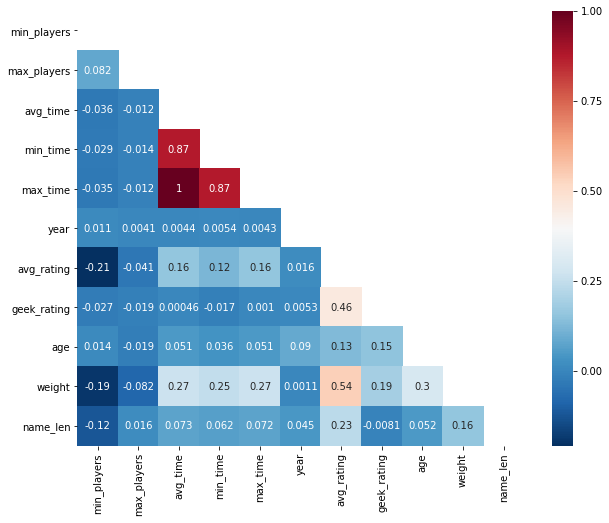

In [9]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,8))
sns.heatmap(corr,mask=mask,annot=True,cmap='RdBu_r')

In [10]:
#drop highly colinear features
df.drop(['min_time','max_time'],axis=1,inplace=True)

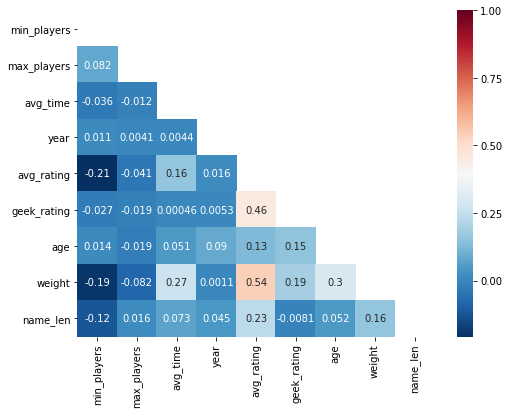

In [11]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8,6))
sns.heatmap(corr,mask=mask,annot=True,cmap='RdBu_r')

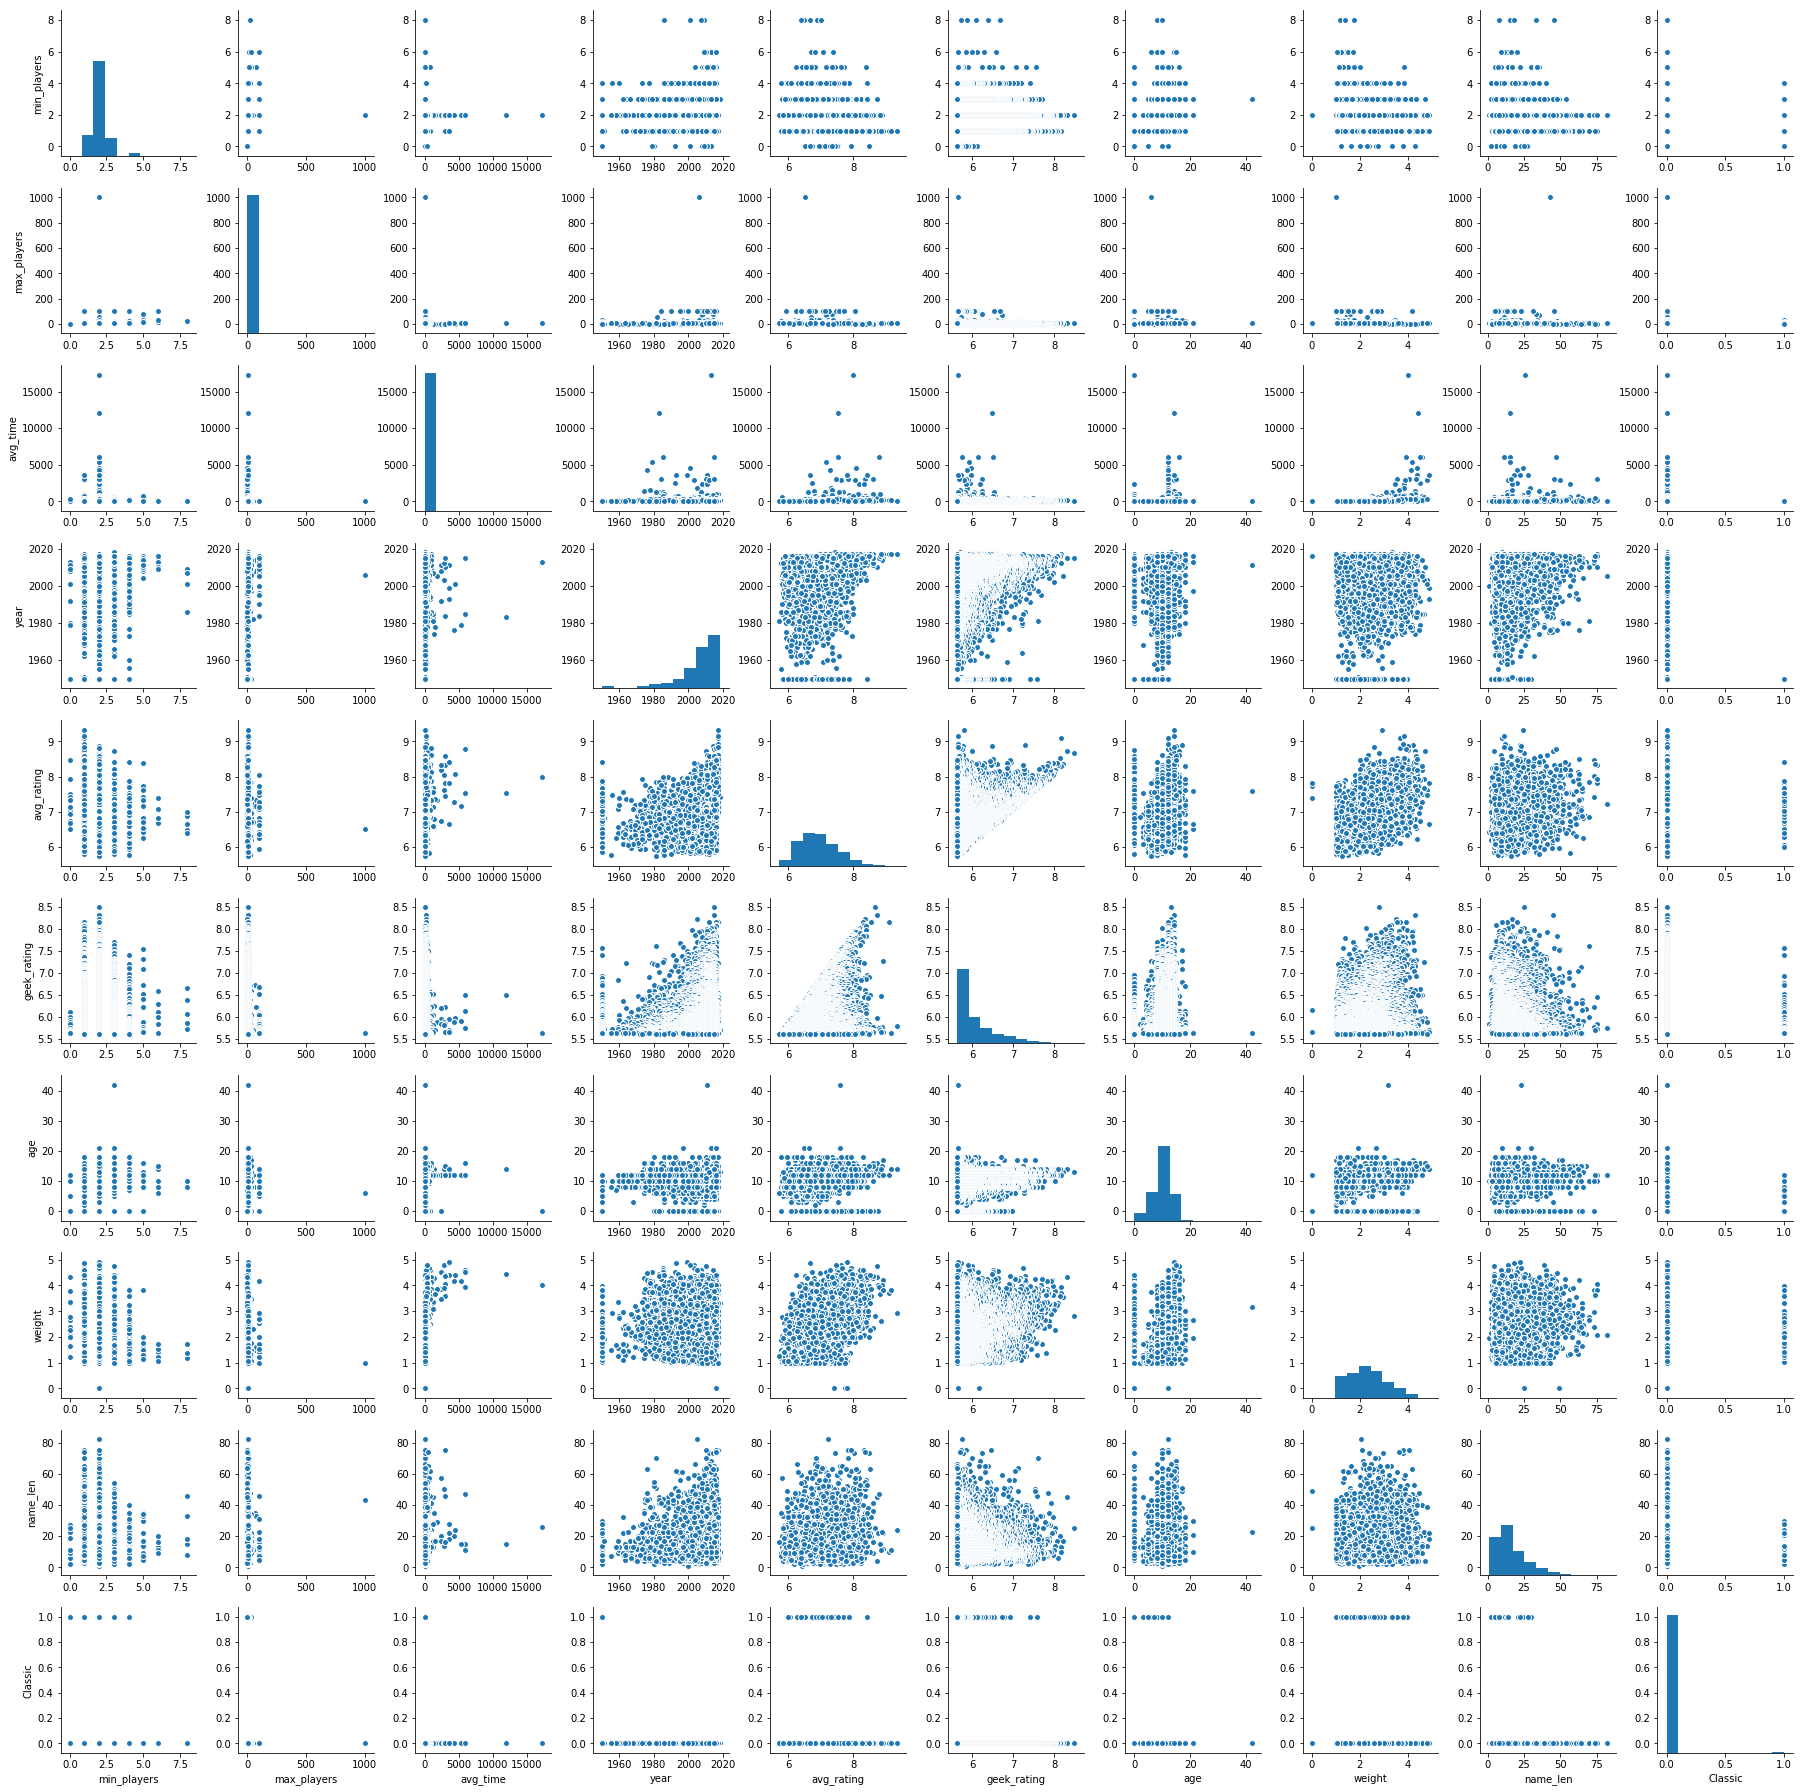

In [70]:
sns.pairplot(df)

In [12]:
#Create year cuttoff of 1950 and mark gams released before 1900 as 'classic'
df['Classic'] = df.year.map(lambda x: 1 if x < 1900 else 0)
df.year = df.year.map(lambda x: 1950 if x < 1950 else x)

In [13]:
df.max_players.value_counts().sort_index()

0        26
1        77
2      1012
3        68
4      1580
5       897
6       797
7        94
8       238
9        16
10       71
11        2
12       42
13        1
15        9
16       10
18        8
20        9
21        2
24        3
30        6
33        2
34        1
52        1
68        1
75        1
99       23
100       1
999       1
Name: max_players, dtype: int64

In [14]:
#Set cap on max_players of 25
df.max_players = df.max_players.map(lambda x: min(x,25))

In [15]:
df.avg_time.value_counts().sort_index()

0         82
1          2
2          2
5         20
10        95
12         1
13         2
15       200
19         1
20       328
25        49
30       786
32         1
35        15
40       100
42         1
45       597
50        25
55         3
60       817
70        14
75        70
80         9
90       504
95         1
100       22
105        1
110        1
115        1
120      481
        ... 
270        1
290        1
300       56
360      114
420        4
480       22
500        1
540        1
600        6
700        1
720        6
750        1
900        2
960        3
1000       2
1200       4
1440       1
1500       1
1800       1
2400       2
2480       1
2880       2
3000       4
3600       3
4320       1
4500       1
5400       1
6000       3
12000      1
17280      1
Name: avg_time, Length: 69, dtype: int64

(0.0, 50)

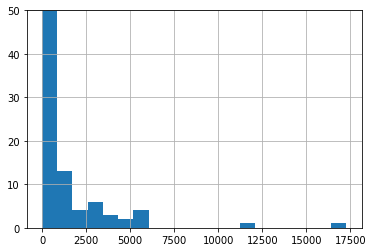

In [16]:
df.avg_time.hist(bins=20)
plt.ylim(ymax=50)

In [17]:
#Enforce a cutoff for the avg_time of 8 hours (480 min)
df.avg_time = df.avg_time.map(lambda x: min(x,480))

In [18]:
df.age = df.age.map(lambda x: min(x,18))

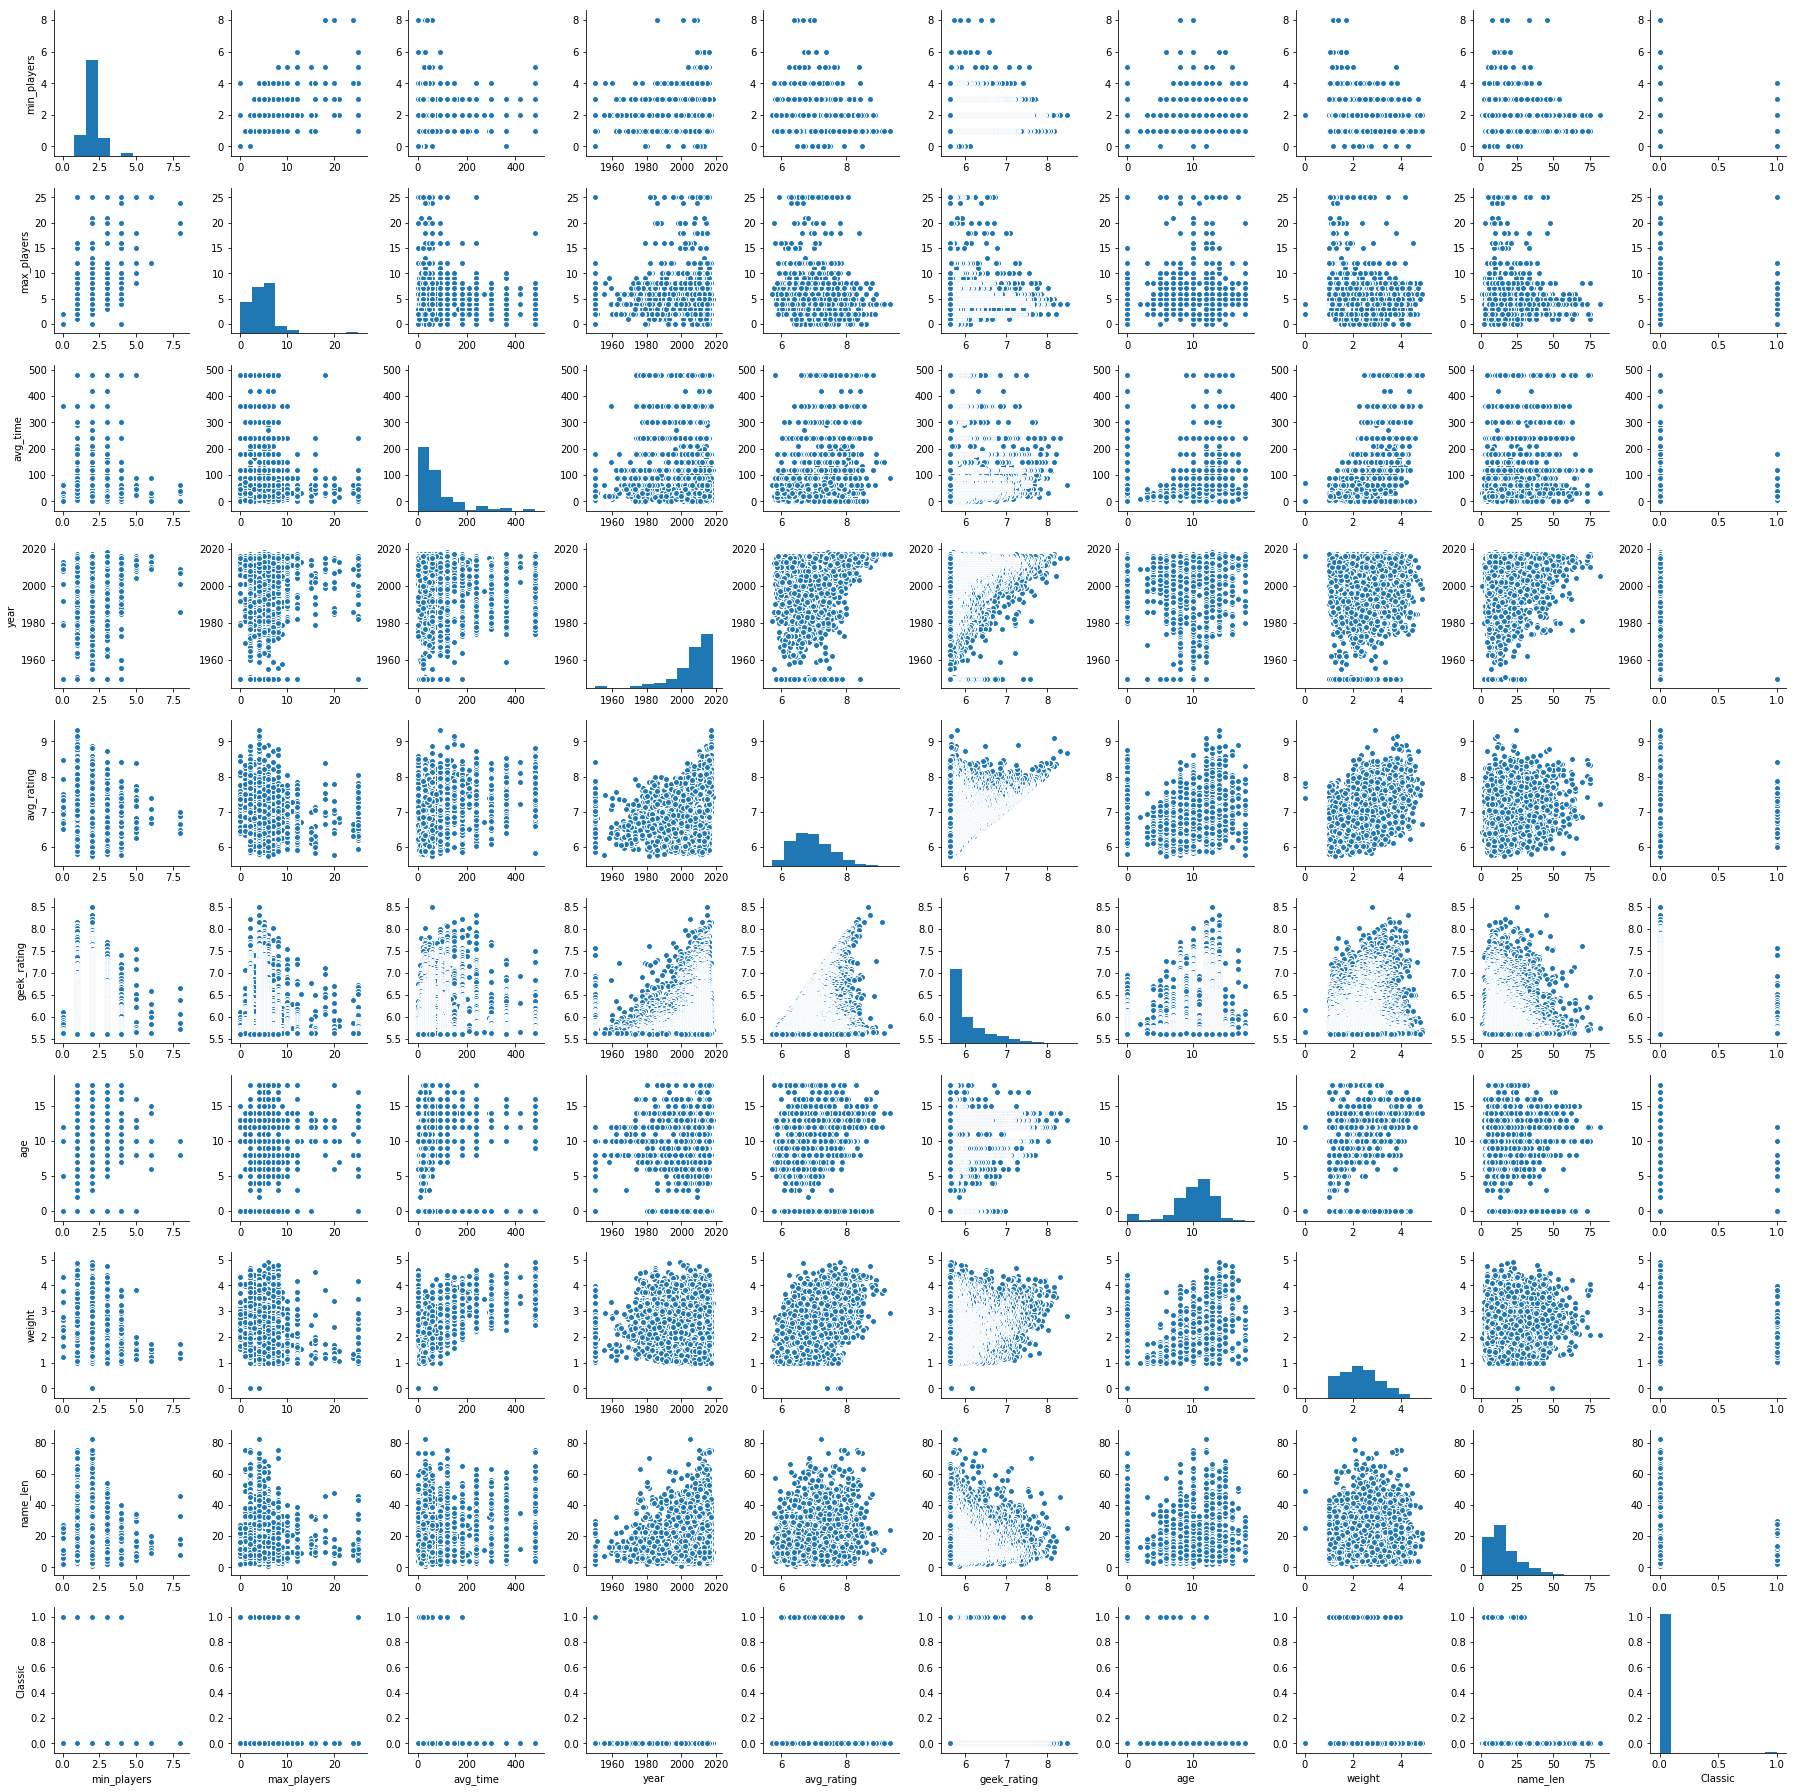

In [90]:
sns.pairplot(df)

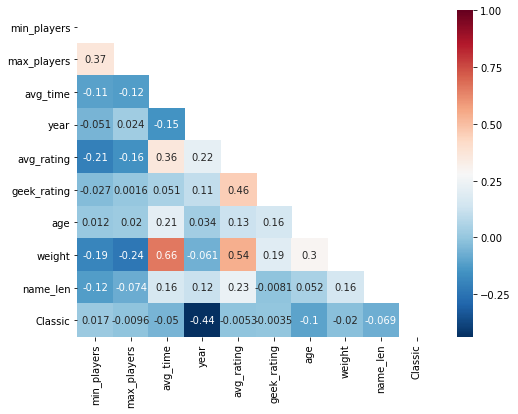

In [19]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8,6))
sns.heatmap(corr,mask=mask,annot=True,cmap='RdBu_r')

Text(0,0.5,'Median Geek Rating')

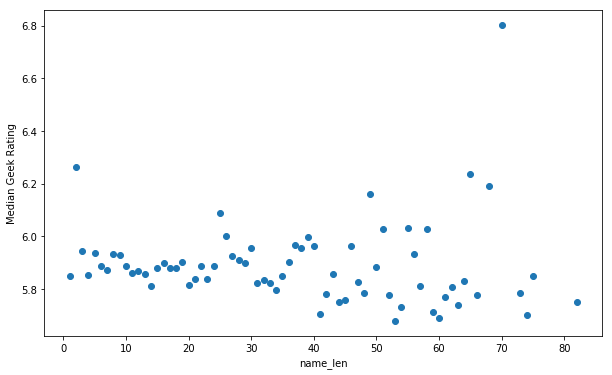

In [20]:
df.groupby('name_len').median()['geek_rating'].plot(figsize=(10,6),marker='o',linestyle='none')
plt.ylabel('Median Geek Rating')

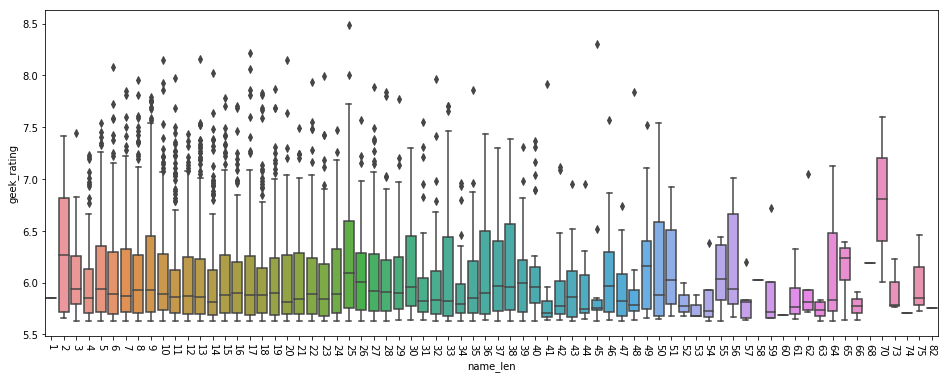

In [21]:
plt.figure(figsize=(16,6))
sns.boxplot('name_len','geek_rating',data=df)#,color=df.groupby('name_len').count()['names'].values)
plt.xticks(rotation=270)
# plt.colorbar()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000236FEE76FD0>]], dtype=object)

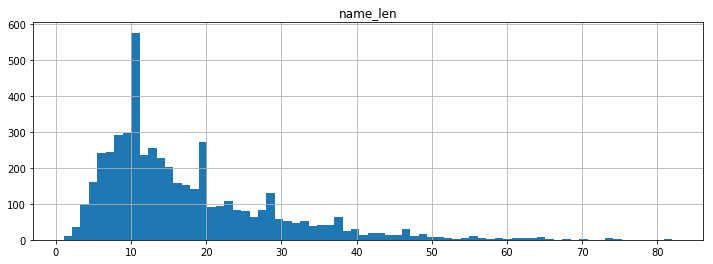

In [22]:
df.hist('name_len',bins=72,figsize=(12,4),)

In [23]:
df.head(3)

,names,min_players,max_players,avg_time,year,avg_rating,geek_rating,age,mechanic,category,designer,weight,name_len,Classic
0,Pandemic Legacy: Season 1,2,4,60,2015,8.66905,8.48904,13,"Action Point Allowance System, Co-operative Pl...","Environmental, Medical","Rob Daviau, Matt Leacock",2.8076,25,0
1,Through the Ages: A New Story of Civilization,2,4,240,2015,8.72977,8.30744,14,"Action Point Allowance System, Auction/Bidding...","Card Game, Civilization, Economic",Vlaada Chvátil,4.3093,45,0
2,Twilight Struggle,2,2,180,2005,8.35745,8.22021,13,"Area Control / Area Influence, Campaign / Batt...","Modern Warfare, Political, Wargame","Ananda Gupta, Jason Matthews",3.5317,17,0


In [98]:
X = df.drop(['geek_rating','avg_rating'],axis=1)
y = df.geek_rating
X_use, X_hold, y_use, y_hold = train_test_split(X,y,test_size=.25)
X_train, X_test, y_train, y_test = train_test_split(X_use,y_use,test_size=.25)

In [99]:
def cleaning(text):
    text = text.split(',')
    text = [word.strip() for word in text]
    return text
cvec = CountVectorizer(analyzer=cleaning)
mech_dummies = pd.DataFrame(cvec.fit_transform(X_train.mechanic).todense(),columns=cvec.get_feature_names())
mech_dummies.head()

,Acting,Action / Movement Programming,Action Point Allowance System,Area Control / Area Influence,Area Enclosure,Area Movement,Area-Impulse,Auction/Bidding,Betting/Wagering,Campaign / Battle Card Driven,...,Take That,Tile Placement,Time Track,Trading,Trick-taking,Variable Phase Order,Variable Player Powers,Voting,Worker Placement,none
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,1,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [435]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    """Select out one or more features and returns them in the shape (n_rows,n_features)"""
    def __init__(self, column):
        self.column = column 
        
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        if type(self.column) == list:
            return X[self.column].values 
        else:
            return X[[self.column]].values 
        

class RowFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select out one feature and return it in the shape (n_rows,)"""
    def __init__(self, column):
        self.column = column 
        
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        return X[self.column].values 

def str_len(x):
    return np.array([len(name) for name in x]).reshape(-1,1)

mechanic_pipe = make_pipeline(
    RowFeatureExtractor('mechanic'),
    CountVectorizer(analyzer=cleaning)
)

category_pipe = make_pipeline(
    RowFeatureExtractor('category'),
    CountVectorizer(analyzer=cleaning)
)

designer_pipe = make_pipeline(
    RowFeatureExtractor('designer'),
    CountVectorizer(analyzer=cleaning)
)

#sigma clipping, minmaxscaling
def sigma_clip(df):
    df = pd.DataFrame(df,columns=['name_len','min_players','max_players','avg_time',
                      'year','avg_rating','num_votes','age','weight'])
    n_low = 3
    n_high = 3
    for col in df.columns:
        mean = df[col].mean()
        std = df[col].std()
        df.loc[df[col]<mean-n_low*std,col] = mean - n_low*std
        df.loc[df[col]>mean+n_high*std,col] = mean + n_high*std
    return df.values
SigmaClipTF = FunctionTransformer(sigma_clip)

numerical_pipe = make_pipeline(
    FeatureExtractor(['name_len','min_players','max_players','avg_time',
                      'year','avg_rating','num_votes','age','weight']),
    SigmaClipTF,
    MinMaxScaler()
)

fu = make_union(
    numerical_pipe,
    mechanic_pipe,
    category_pipe,
    designer_pipe
)

In [456]:
pipe = Pipeline([
    ('fu',fu),
    ('svd',TruncatedSVD(150)),
    ('lr',GridSearchCV(RandomForestRegressor(),
            param_grid={'n_estimators':[10,20,30,40,50],
                       'max_depth':[None,5,10,20,30]},
            scoring='neg_mean_squared_error'))
])

In [458]:
gs = GridSearchCV(pipe,param_grid={'svd__n_components':[50,100,150,200]},\
                  scoring='neg_mean_squared_error',verbose=2)
gs.fit(X_train,y_train)
abs(gs.score(X_train,y_train))**.5,abs(gs.score(X_test,y_test))**.5

(0.14181913777404509, 0.35237586895320683)

In [453]:
mean_squared_error(y_train,gs.predict(X_train))**.5,mean_squared_error(y_test,gs.predict(X_test))**.5

(0.14186331928438956, 0.34993865203973284)

In [ ]:
(0.89971978239510575, 0.40601056322652596)

In [449]:
gs.best_params_,gs.best_estimator_.named_steps['lr'].best_params_

({'svd__n_components': 100}, {'max_depth': None, 'n_estimators': 40})

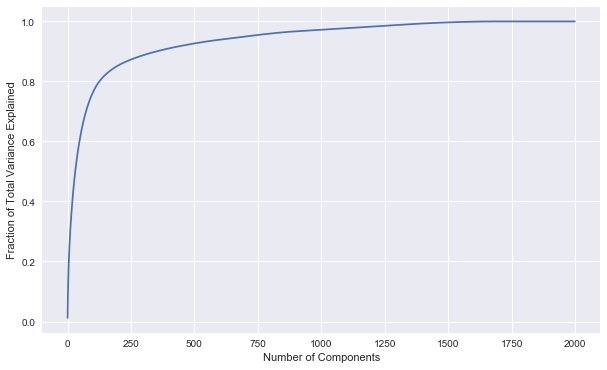

In [389]:
plt.figure(figsize=(10,6))
plt.plot(range(2000),pipe.named_steps['svd'].explained_variance_ratio_.cumsum())
# plt.vlines(200,0,1,linestyles='dashed',alpha=.5)
plt.xlabel('Number of Components')
plt.ylabel('Fraction of Total Variance Explained')

In [396]:
grid = {
    'lr': [GridSearchCV(RandomForestRegressor(),
            param_grid={'n_estimators':np.arange(10,50,10),
                        'max_depth':[5,10,15],
                       'max_features':['sqrt']}),
        GridSearchCV(KNeighborsRegressor(),
            param_grid={'n_neighbors':[3,5,7]}),
        GridSearchCV(ElasticNet(),
            param_grid={'alpha':[.1,1,10],
                       'l1_ratio':[.25,.5,.75,.9],
                       'fit_intercept':[True,False]})]    
}

In [398]:
gs = GridSearchCV(pipe,param_grid=grid,verbose=1)
gs.fit(X_train,y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.3min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('fu', FeatureUnion(n_jobs=1,
       transformer_list=[('pipeline-1', Pipeline(steps=[('featureextractor', FeatureExtractor(column=['name_len', 'min_players', 'max_players', 'avg_time', 'year', 'avg_rating', 'num_votes', 'age', 'weight'])), ('functiontransformer', FunctionTransformer(accept_s...timators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'lr': [GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weig...     pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
  

In [402]:
gs.best_score_

0.3539825464301507

In [330]:
import sqlite3 as sq3

# Read sqlite query results into a pandas DataFrame
con = sq3.connect("datasets/database.sqlite")
df = pd.read_sql_query('select * from BoardGames', con)

con.close()

In [331]:
df.head(1)

,row_names,game.id,game.type,details.description,details.image,details.maxplayers,details.maxplaytime,details.minage,details.minplayers,details.minplaytime,...,stats.family.arcade.bayesaverage,stats.family.arcade.pos,stats.family.atarist.bayesaverage,stats.family.atarist.pos,stats.family.commodore64.bayesaverage,stats.family.commodore64.pos,stats.subtype.rpgitem.bayesaverage,stats.subtype.rpgitem.pos,stats.subtype.videogame.bayesaverage,stats.subtype.videogame.pos
0,1,1,boardgame,Die Macher is a game about seven sequential po...,//cf.geekdo-images.com/images/pic159509.jpg,5.0,240.0,14.0,3.0,240.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [332]:
a = np.array([1,2,3,4,5,6,7,8,9])
a.mean()

5.0

In [334]:
C=1
(C*a.mean() + a.sum())/(C+len(a))

5.0

In [121]:
url = 'https://www.boardgamegeek.com/xmlapi2/thing?'
ids = np.arange(1,110317+1)
begin_index = 0
end_index = 100
ids = ','.join(nums.astype(str))
res = requests.get(url,{'id':1,'stats':'1','marketplace':'1','type':'boardgame'})

In [83]:
foo = xmltodict.parse(res.content)

In [178]:
# begin_index = 0
# end_index = 100
# games_list = []
while end_index <= 110300:
    ids = np.arange(begin_index,end_index).astype(str)
    ids = ','.join(ids)
    res = requests.get(url,{'id':ids,'stats':'1','marketplace':'1','type':'boardgame'})
    d = xmltodict.parse(res.content)
    if 'items' in d.keys():
        games_list += d['items']['item']
    print (res.status_code,end_index)
    begin_index += 100
    end_index += 100
    time.sleep(5)

200 110300


In [179]:
end_index

110400

In [175]:
res = requests.get(url,{'id':ids,'stats':'1','marketplace':'1','type':'boardgame'})
d = xmltodict.parse(res.content)

In [169]:
'items' in d.keys()

False

In [180]:
len(games_list)

49238

In [177]:
games_list[-1]

OrderedDict([('@type', 'boardgame'),
             ('@id', '110194'),
             ('thumbnail',
              'https://cf.geekdo-images.com/images/pic1236413_t.jpg'),
             ('image', 'https://cf.geekdo-images.com/images/pic1236413.jpg'),
             ('name',
              OrderedDict([('@type', 'primary'),
                           ('@sortindex', '1'),
                           ('@value', 'Count Down Space Game')])),
             ('description',
              '1959 Toy Rocket Space Game by the Trans-o-gram Co. Yep, the same company that made cookie cutters and other baking products!&#10;&#10;Cover states: &quot;Force enemy rockets out of orbit.... and CONQUER OUTER SPACE!&#10;&#10;A simple game with a spinner (1-6 values) where players move their rockets to knock others out of orbit by moving their rocket on a atomic symbol shaped track to collide with an opponents rocket to take it out of orbit.&#10;&#10;'),
             ('yearpublished', OrderedDict([('@value', '1959')])),
